In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
import random
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)

## **Load the Data**

In [2]:
train = pd.read_csv('/content/train_kdd_nsl.csv')
test = pd.read_csv('/content/test_kdd_nsl.csv')

In [3]:
train = train.drop_duplicates()
train = train.drop(columns = ['service','land','wrong_fragment','urgent','hot','num_failed_logins','rerror_rate','srv_rerror_rate','is_guest_login','is_hot_login','num_outband_cmds','num_access_files','num_shells','num_compromised'],axis=0)

In [4]:
test = test.drop_duplicates()
test = test.drop(columns = ['service','land','wrong_fragment','urgent','hot','num_failed_logins','rerror_rate','srv_rerror_rate','is_guest_login','is_hot_login','num_outband_cmds','num_access_files','num_shells','num_compromised'],axis=0)

In [5]:
train = train.loc[(train["connection_type"] == 'normal')|(train["connection_type"] == 'satan')]
test = test.loc[(test["connection_type"] == 'normal')|(test["connection_type"] == 'satan')]

In [6]:
train = train.reset_index(drop = True)   #reset index for the train data
test = test.reset_index(drop = True)     #reset index for the test data

In [7]:
train['protocole_type'] = [0.8 if elem == 'tcp' else 0.15 if elem == 'udp' else 0.05 for elem in train['protocole_type']]
train['flag'] = [0.6 if elem=='SF' else 0.2 if elem=='S0' else 0.1 if elem=='REJ' else 0.05 for elem in train['flag']]

In [8]:
test['protocole_type'] = [0.8 if elem == 'tcp' else 0.15 if elem == 'udp' else 0.05 for elem in test['protocole_type']]
test['flag'] = [0.6 if elem=='SF' else 0.2 if elem=='S0' else 0.1 if elem=='REJ' else 0.05 for elem in test['flag']]

In [9]:
#This function is used to encode a vector as follows:
'''
when the vector element == 'normal', it will be transformed to 1 and to 0 if not
'''
def encoding(y):
  enc = [1 if y[i]=='normal' else 0 for i in range(len(y))]
  return pd.DataFrame(enc)

In [10]:
y_train = train['connection_type']
y_test = test['connection_type']

In [11]:
y_train = encoding(y_train)
y_test = encoding(y_test)

In [12]:
train = train.drop(['connection_type'],axis=1)
test = test.drop(['connection_type'],axis=1)

In [13]:
scaler = MinMaxScaler()
train = scaler.fit_transform(train)
train = np.array(train)
train = train / train.sum(axis=1, keepdims=True)
train = np.clip(train,0.0000005,None)

In [14]:
scaler = MinMaxScaler()
test = scaler.fit_transform(test)
test = np.array(test)
test = test / test.sum(axis=1, keepdims=True)
test = np.clip(test,0.0000005,None)

## **Expectation Step**

In [15]:
from scipy.special import gamma, digamma, gammaln, psi,polygamma
def log_dir(row,alphas):
  log_dir = []
  for alpha in alphas:
    q = gammaln(np.sum(alpha)) - np.sum(gammaln(alpha)) + np.sum((alpha-1)*np.log(row))
    log_dir.append(q)
  return np.array(log_dir)

In [16]:
def expectation_step(data, alphas, P,number_of_clusters):
    Z = np.zeros((len(data), number_of_clusters))

    for i, row in enumerate(data):
        log_posteriors = np.log(P) + log_dir(row, alphas)
        log_posteriors -= np.max(log_posteriors)
        posteriors = np.exp(log_posteriors)
        Z[i] = posteriors / np.sum(posteriors)
    return Z

## **Maximization Step** ##

In [17]:
def update_P(Z):
  return np.mean(Z,axis=0)

In [18]:
def normalize_alpha(arr, m, M):
    min_val = min(arr)
    max_val = max(arr)
    normalized_arr = []

    for value in arr:
        normalized_value = m + ((value - min_val) * (M - m) / (max_val - min_val))
        normalized_arr.append(normalized_value)

    return normalized_arr

In [19]:
def calcul_inv_hess_vect(data,alpha,Z,number_of_clusters):
  ((N, K),M) = (data.shape,number_of_clusters)
  Z_mean = np.clip(np.mean(Z,axis=0),10**(-15),None)
  inv_hess_vect_matrices = []
  for j in range(M):
    alpha_j = alpha[j]
    S = np.diag([-1/np.clip(float(polygamma(1,alpha_j[m]))*N*Z_mean[j],10**(-7),None) for m in range(K)])
    a_T = np.array([[-1/np.clip(float(polygamma(1,alpha_j[m]))*N*Z_mean[j],10**(-7),None) for m in range(K)]])
    gamma_et = float(polygamma(1,np.sum(alpha_j)))*N*Z_mean[j] / (1+float(polygamma(1,np.sum(alpha_j)))*N*Z_mean[j]*np.sum([-1/np.clip(float(polygamma(1,alpha_j[m]))*N*Z_mean[j],10**(-7),None) for m in range(K)]))
    H_inv = S + gamma_et*np.dot(a_T.T,a_T)
    inv_hess_vect_matrices.append(H_inv)
  return inv_hess_vect_matrices

In [20]:
def derivative(data,alpha_old,Z,number_of_clusters):
  ((N, K),M) = (data.shape,number_of_clusters)
  Z_mean = np.mean(Z,axis=0)
  der_param = []
  for j in range(M):
    der_vect_alpha_j = np.zeros(K)
    alpha_old_j = alpha_old[j]
    for s in range(K):
      der_vect_alpha_j[s] =N*Z_mean[j]*(psi(np.sum(alpha_old_j)) - psi(alpha_old_j[s])) - np.sum( Z[:,j]*np.log(data[:,s]) )
    der_param.append(der_vect_alpha_j)
  return der_param

In [21]:
def update_alpha(data,alpha_old,Z,number_of_clusters):
  M = number_of_clusters
  inv_hess = calcul_inv_hess_vect(data,alpha_old,Z,number_of_clusters)
  der_param = derivative(data,alpha_old,Z,number_of_clusters)
  alpha_new = []
  for j in range(M):
    (alpha_old_j,der_param_j,Hess_j) = (alpha_old[j],der_param[j],inv_hess[j])
    alpha_new_j = alpha_old_j - np.dot(Hess_j,der_param_j)
    alpha_new.append(np.array(normalize_alpha(np.array(alpha_new_j),0.1,10)))
  return alpha_new

In [22]:
#After several realizations of initialization, this initialization gave us the best results
alpha_zero = [np.array([2.30850816, 9.53221521, 4.52654125, 8.47944586, 7.02484483,
       3.04462581, 8.15659842, 4.02540683, 8.82292165, 5.85460144,
       8.82918008, 6.95606274, 7.28001737, 5.06311138, 9.56522798,
       6.47550297, 4.29616498, 6.10329282, 0.29001266, 3.08559069,
       6.63571802, 2.97176831, 6.21835275, 4.34481014, 1.44119324,
       3.05299503, 5.74265262]), np.array([5.94964034, 5.78581996, 6.56668812, 6.55582237, 4.37104251,
       8.9758113 , 3.73886251, 4.41506276, 8.93004121, 8.08132049,
       7.06849698, 1.09224618, 9.20287788, 7.17098887, 9.98858537,
       1.57953822, 8.69444797, 1.70868005, 6.19403969, 1.32581783,
       8.49528147, 8.09245769, 5.73409731, 4.13111464, 0.78475326,
       7.00454485, 4.59007256])]

In [23]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, accuracy_score
from sklearn import metrics

x_train_task = train
x_test_task = test

#EM Algorithm
M = 2
P = [0.5, 0.5]
alpha_old = alpha_zero
max_iter = 3
for iteration in range(max_iter):
  Z = expectation_step(x_train_task,alpha_old,P,M)
  alpha_new = update_alpha(x_train_task,alpha_old,Z,M)
  P = np.clip(update_P(Z),10**(-15),None)
  alpha_old = alpha_new

In [24]:
#Sometimes we need to switch the positions of the parameters to slove the label switching problem
alpha_new = [alpha_new[1],alpha_new[0]]

In [25]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, accuracy_score
from sklearn import metrics

predictions_bin = []
for row in x_test_task:
      log_posteriors = np.exp(np.log(P)+log_dir(row,alpha_new))
      predicted_label = np.argmax(log_posteriors)
      predictions_bin.append(predicted_label)
predictions_bin = np.asarray(predictions_bin)
labels = np.array(y_test).flatten()
f1 = f1_score(labels, predictions_bin)
precision = precision_score(labels, predictions_bin)
recall = recall_score(labels, predictions_bin)
acc = accuracy_score(labels, predictions_bin)

print("F1 score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", acc)

F1 score: 0.9270132852222404
Precision: 0.9881118881118881
Recall: 0.8730305838739574
Accuracy: 0.8721998851234922


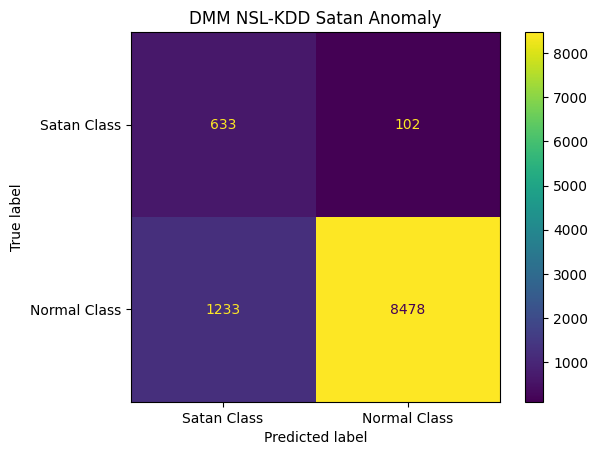

In [27]:
cm = confusion_matrix(labels, predictions_bin)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['Satan Class', 'Normal Class'])
cm_display.plot()
cm_display.ax_.set_title('DMM NSL-KDD Satan Anomaly')
plt.show()